# DSC 232R: Week 5 Discussion Session
## Vectors, RMSE, and The Curse of Dimensionality

**Topics:**
1.  **Functions as Vectors**
2.  **The RMSE Methodology**
3.  **Data in High Dimensions**

---

# Part 1: Functions as Vectors

### Theoretical Background

In Data Science, we are used to thinking of vectors as arrows in 2D or 3D space, like $\vec{v} = [x, y, z]$. However, many real-world data sources are **functions**.

**The Weather Example:**
Consider the temperature of a city recorded every day for a year.
* Mathematically, this is a function $T(t)$ where $t$ is the day (1 to 365).
* Computationally, we store this as a vector with 365 dimensions: $\vec{v} \in \mathbb{R}^{365}$.

### Basis Functions
Just as we can write any 3D vector as a sum of $x, y, z$ coordinates, we can write any function as a sum of **Basis Functions**.

We want to approximate a complex function $f(x)$ using a linear combination of simpler functions $u_i$:

$$ g_k = \sum_{i=0}^{k} (f \cdot u_i) u_i $$

Where:
* $u_i$ are the **Basis Vectors** (e.g., Sine and Cosine waves).
* $(f \cdot u_i)$ is the **Projection** (Dot Product), representing the coefficient or "weight" of that basis vector.

### Orthonormality
For this to work efficiently, our basis vectors must be **Orthonormal**:
1.  **Orthogonal:** The dot product of any two distinct basis vectors is 0 ($\vec{u}_i \cdot \vec{u}_j = 0$).
2.  **Normalized:** The length (norm) of each basis vector is 1 ($|\vec{u}_i|^2 = 1$).

If the basis is orthonormal, we don't need to solve complex systems of equations to find the weights; we just take the dot product!

### Implementation
Let's construct a sinusoidal basis (Fourier basis) and use it to approximate a target function $f(x) = x - 4$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi

# 1. Setup the Domain
# We use 365 days as our dimension, similar to the weather data in slides.
N = 365
x = np.linspace(0, 2*pi, N) # The domain [0, 2pi] mapped to 365 points
step = (2*pi) / N           # dx

# 2. Define the Orthonormal Basis
# Normalization constant c = sqrt(step/pi) ensures the integral (sum) is 1.
c = sqrt(step / pi)

basis_vectors = []

# Basis 0: Constant vector (The "Mean" or DC component)
# Note: It has a specific scaling factor to ensure norm is 1
v0 = np.ones_like(x) * (c / sqrt(2))
basis_vectors.append(v0)

# Basis 1..8: Sin and Cos pairs (Frequencies 1, 2, 3, 4)
for k in range(1, 5):
    basis_vectors.append(np.sin(k * x) * c)
    basis_vectors.append(np.cos(k * x) * c)

# Stack them into a Matrix U (rows are basis vectors)
U = np.vstack(basis_vectors)

print(f"Basis Matrix U shape: {U.shape} (9 Basis Vectors x 365 Time Steps)")

# 3. Check Orthonormality
# If orthonormal, U dot U_transpose should be the Identity Matrix
gram_matrix = U @ U.T
print("\nCheck: Dot product of basis vectors (Rounded):")
print(np.round(gram_matrix, 1))

Basis Matrix U shape: (9, 365) (9 Basis Vectors x 365 Time Steps)

Check: Dot product of basis vectors (Rounded):
[[ 1. -0.  0. -0.  0. -0.  0. -0.  0.]
 [-0.  1. -0.  0. -0.  0. -0. -0.  0.]
 [ 0. -0.  1. -0.  0.  0.  0. -0.  0.]
 [-0.  0. -0.  1. -0. -0.  0.  0. -0.]
 [ 0. -0.  0. -0.  1. -0.  0. -0.  0.]
 [-0.  0.  0. -0. -0.  1. -0. -0.  0.]
 [ 0. -0.  0.  0.  0. -0.  1. -0.  0.]
 [-0. -0. -0.  0. -0. -0. -0.  1.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  1.]]


### Approximating a Function
Now we generate a target function $f(x) = x - 4$. We will project this target onto our basis vectors one by one to see how the reconstruction improves.

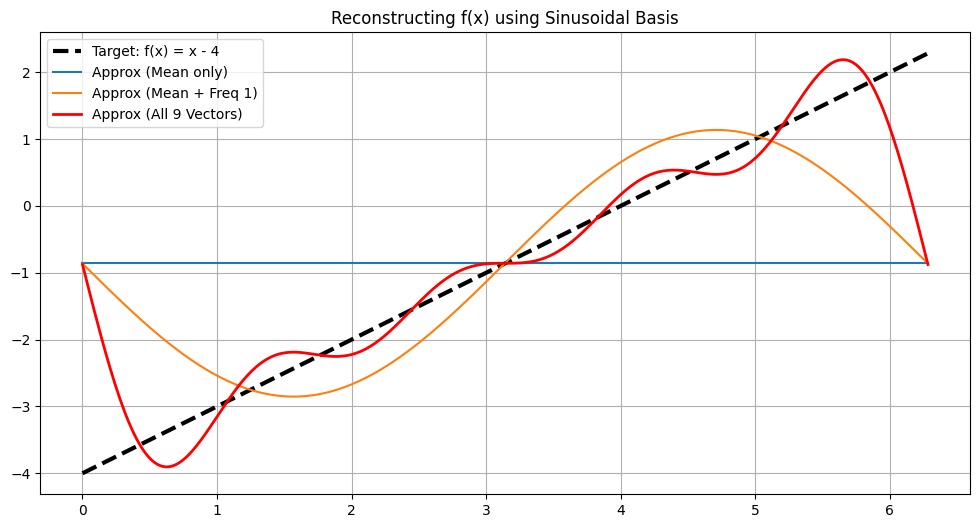

In [2]:
# 1. Define Target Function
target_f = x - 4

# 2. Reconstruct iteratively
reconstructions = []
current_approximation = np.zeros_like(x)

plt.figure(figsize=(12, 6))

# Loop through our 9 basis vectors
for i in range(len(basis_vectors)):
    basis_vec = U[i]

    # Calculate Projection Coefficient (Dot Product)
    # This single number tells us "how much" of this basis vector is in the target
    coefficient = np.dot(target_f, basis_vec)

    # Add weighted basis vector to approximation
    current_approximation = current_approximation + (coefficient * basis_vec)
    reconstructions.append(current_approximation.copy())

# Plotting the results
plt.plot(x, target_f, 'k--', linewidth=3, label='Target: f(x) = x - 4')
plt.plot(x, reconstructions[0], label='Approx (Mean only)')
plt.plot(x, reconstructions[2], label='Approx (Mean + Freq 1)')
plt.plot(x, reconstructions[-1], 'r-', linewidth=2, label='Approx (All 9 Vectors)')

plt.grid(True)
plt.legend()
plt.title("Reconstructing f(x) using Sinusoidal Basis")
plt.show()

---
# Part 2: The RMSE Methodology

### Theoretical Background

How do we mathematically quantify how good our approximation is? We use the **Root Mean Square Error (RMSE)**.


$$ RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} || \vec{x}_i - \vec{o}_i ||^2_2} $$

Where:
* $\vec{x}_i$ is the real data point.
* $\vec{o}_i$ is the model output (prediction/reconstruction).
* $N$ is the number of samples.

### Intensive vs. Extensive Properties
* **Extensive:** Scales with the size of data (e.g., the raw vector $\vec{x}$ gets larger as we add more days).
* **Intensive:** Does not scale with data size (e.g., the Model Parameters or the Basis definitions).

A good model reduces the dimension (from 365 raw numbers to just 9 coefficients) with only a small increase in RMSE.

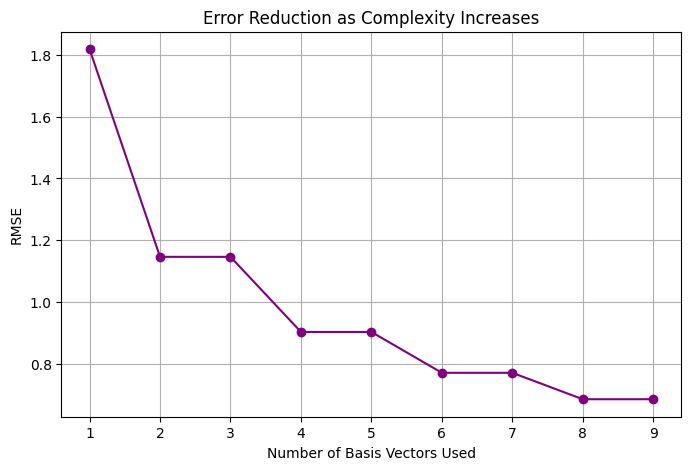

Initial RMSE (Mean only): 1.8188
Final RMSE (9 vectors):   0.6848


In [3]:
def calculate_rmse(target, prediction):
    mse = np.mean((target - prediction)**2)
    return np.sqrt(mse)

# Calculate RMSE for each step of our previous reconstruction
errors = [calculate_rmse(target_f, recon) for recon in reconstructions]

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), errors, 'o-', color='purple')
plt.xlabel("Number of Basis Vectors Used")
plt.ylabel("RMSE")
plt.title("Error Reduction as Complexity Increases")
plt.grid(True)
plt.xticks(range(1, 10))
plt.show()

print(f"Initial RMSE (Mean only): {errors[0]:.4f}")
print(f"Final RMSE (9 vectors):   {errors[-1]:.4f}")

---
# Part 3: Data in High Dimensions

### Theoretical Background

As data scientists, we often work with vectors that have hundreds or thousands of dimensions (images, genomic data, embeddings).

**Our intuition from 2D and 3D fails in high dimensions ($d \to \infty$).**

### Phenomenon 1: Concentration of Norm
If you draw a random vector from a Gaussian distribution in very high dimensions, its length (norm) is not random. It is tightly concentrated around $\sqrt{d}$.

$$ E[||x||^2] = d $$

This means all points sit on a thin "shell" away from the origin.

### Phenomenon 2: The Curse of Dimensionality (Distances)
In high dimensions, the concept of "Nearest Neighbors" breaks down.
If we have two clusters of data, in 2D they look separated. In 2000D, the distance *between* points in the same cluster becomes almost as large as the distance to points in the *other* cluster.

Let's demonstrate this failure using code.

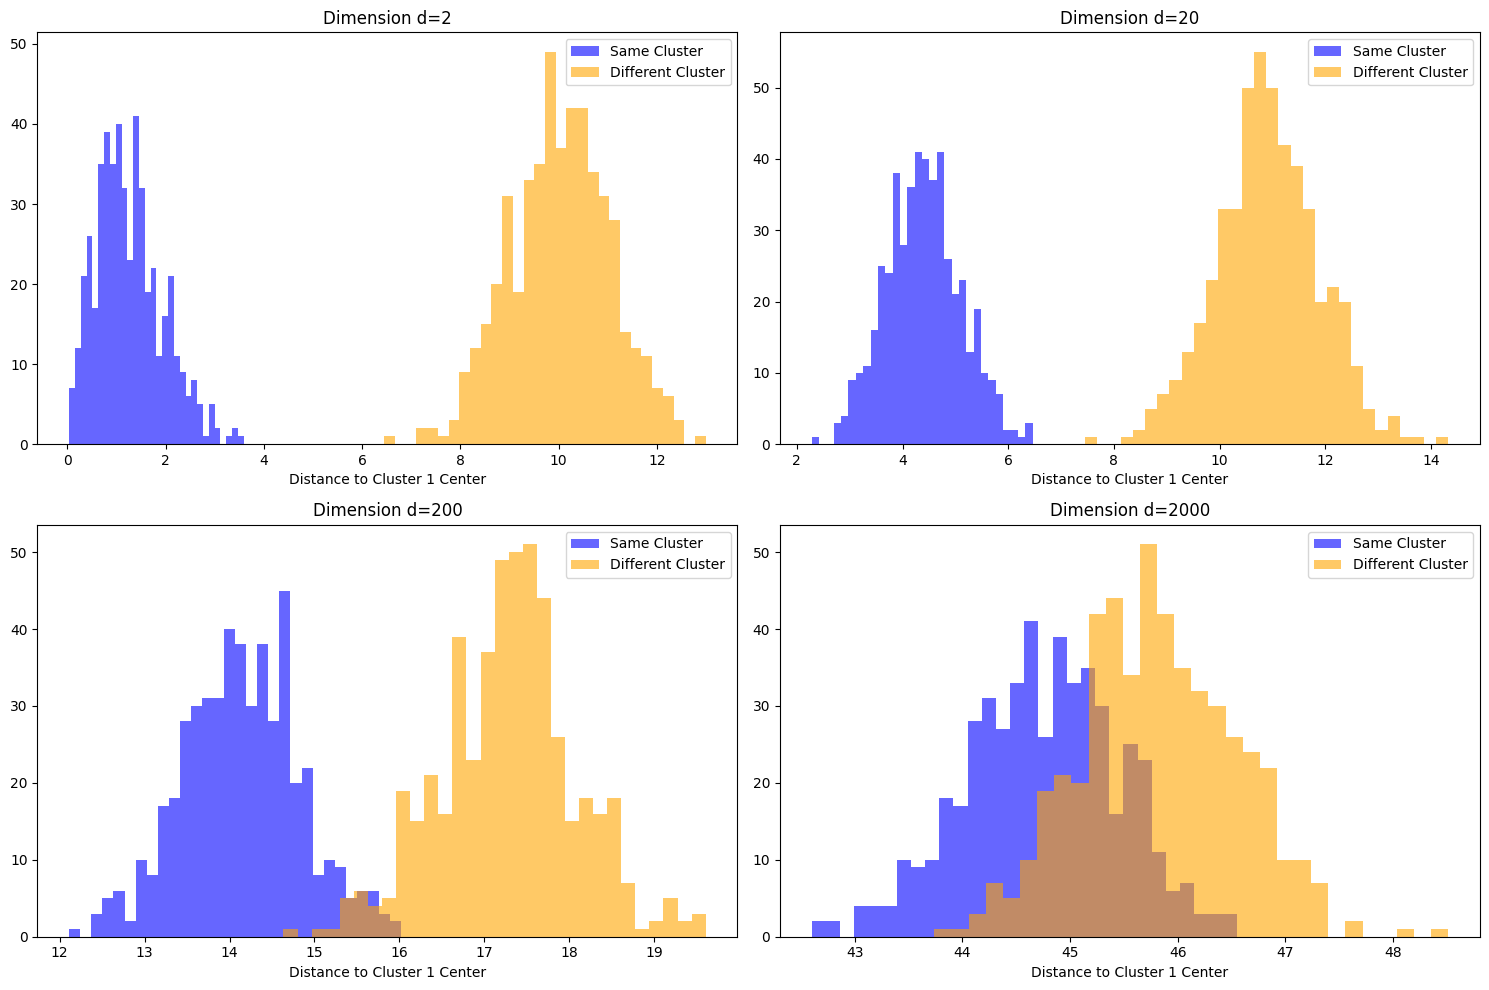

In [4]:
def experiment_high_dim_distances(dims_list=[2, 20, 200, 2000], n_samples=1000):
    plt.figure(figsize=(15, 10))

    for i, d in enumerate(dims_list):
        # Create two clusters of data
        # Cluster 1: Centered at [-5, 0, ...]
        mean1 = np.zeros(d)
        mean1[0] = -5
        X1 = np.random.randn(n_samples // 2, d) + mean1

        # Cluster 2: Centered at [+5, 0, ...]
        mean2 = np.zeros(d)
        mean2[0] = 5
        X2 = np.random.randn(n_samples // 2, d) + mean2

        # Measure distances from points in X1 and X2 to the Center of Cluster 1
        # Intra-cluster: Distance from X1 points to Mean 1
        dist_intra = np.linalg.norm(X1 - mean1, axis=1)

        # Inter-cluster: Distance from X2 points to Mean 1
        dist_inter = np.linalg.norm(X2 - mean1, axis=1)

        # Plotting
        plt.subplot(2, 2, i+1)
        plt.hist(dist_intra, bins=30, alpha=0.6, label='Same Cluster', color='blue')
        plt.hist(dist_inter, bins=30, alpha=0.6, label='Different Cluster', color='orange')
        plt.title(f"Dimension d={d}")
        plt.xlabel(f"Distance to Cluster 1 Center")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Run the experiment
experiment_high_dim_distances()

### Interpreting the Results

1.  **d=2 (Top Left):** The distributions are completely separated. A simple threshold distinguishes the clusters. The distances are small.
2.  **d=2000 (Bottom Right):**
    * Look at the x-axis! The distances are massive (~45).
    * The "noise" in the 1999 other dimensions dominates the "signal" (the separation of +/- 5 in the first dimension).
    * While they look separated here, relative to the total length of the vector, the difference becomes negligible.
    * This is why **k-Nearest Neighbors (k-NN)** often fails in high dimensions without dimensionality reduction (like PCA).